In [1]:
"""
Phase Estimation Benchmark Program - Qiskit
"""

import sys
import time

import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister

sys.path[1:1] = ["_common", "_common/qiskit", "quantum-fourier-transform/qiskit"]
sys.path[1:1] = ["../../_common", "../../_common/qiskit", "../../quantum-fourier-transform/qiskit"]
import execute as ex
import metrics as metrics
from qft_benchmark import inv_qft_gate

# Benchmark Name
benchmark_name = "Phase Estimation"

np.random.seed(0)

verbose = False

# saved subcircuits circuits for printing
QC_ = None
QFTI_ = None
U_ = None

In [2]:
############### Circuit Definition

def PhaseEstimation(num_qubits, theta):
    
    qr = QuantumRegister(num_qubits)
    
    num_counting_qubits = num_qubits - 1 # only 1 state qubit
    
    cr = ClassicalRegister(num_counting_qubits)
    qc = QuantumCircuit(qr, cr, name=f"qpe-{num_qubits}-{theta}")

    # initialize counting qubits in superposition
    for i in range(num_counting_qubits):
        qc.h(qr[i])

    # change to |1> in state qubit, so phase will be applied by cphase gate
    qc.x(num_counting_qubits)

    qc.barrier()

    repeat = 1
    for j in reversed(range(num_counting_qubits)):
        # controlled operation: adds phase exp(i*2*pi*theta*repeat) to the state |1>
        #                       does nothing to state |0>
        cp, _ = CPhase(2*np.pi*theta, repeat)
        qc.append(cp, [j, num_counting_qubits])
        repeat *= 2

    #Define global U operator as the phase operator
    _, U = CPhase(2*np.pi*theta, 1)

    qc.barrier()
    
    # inverse quantum Fourier transform only on counting qubits
    qc.append(inv_qft_gate(num_counting_qubits), qr[:num_counting_qubits])
    
    qc.barrier()
    
    # measure counting qubits
    qc.measure([qr[m] for m in range(num_counting_qubits)], list(range(num_counting_qubits)))

    # save smaller circuit example for display
    global QC_, U_, QFTI_
    if QC_ == None or num_qubits <= 5:
        if num_qubits < 9: QC_ = qc
    if U_ == None or num_qubits <= 5:
        if num_qubits < 9: U_ = U
    if QFTI_ == None or num_qubits <= 5:
        if num_qubits < 9: QFTI_ = inv_qft_gate(num_counting_qubits)
    return qc

#Construct the phase gates and include matching gate representation as readme circuit
def CPhase(angle, exponent):

    qc = QuantumCircuit(1, name=f"U^{exponent}")
    qc.p(angle*exponent, 0)
    phase_gate = qc.to_gate().control(1)

    return phase_gate, qc

# Analyze and print measured results
# Expected result is always theta, so fidelity calc is simple
def analyze_and_print_result(qc, result, num_counting_qubits, theta, num_shots):

    # get results as measured counts
    counts = result.get_counts(qc)  

    # calculate expected output histogram
    correct_dist = theta_to_bitstring(theta, num_counting_qubits)
    
    # generate thermal_dist to be comparable to correct_dist
    thermal_dist = metrics.uniform_dist(num_counting_qubits)

    # convert counts, expectation, and thermal_dist to app form for visibility
    # app form of correct distribution is measuring theta correctly 100% of the time
    app_counts = bitstring_to_theta(counts, num_counting_qubits)
    app_correct_dist = {theta: 1.0}
    app_thermal_dist = bitstring_to_theta(thermal_dist, num_counting_qubits)

    if verbose:
        print(f"For theta {theta}, expected: {correct_dist} measured: {counts}")
        print(f"   ... For theta {theta} thermal_dist: {thermal_dist}")
        print(f"For theta {theta}, app expected: {app_correct_dist} measured: {app_counts}")
        print(f"   ... For theta {theta} app_thermal_dist: {app_thermal_dist}")
        
    # use polarization fidelity with rescaling
    fidelity = metrics.polarization_fidelity(counts, correct_dist, thermal_dist)
    
    # use polarization fidelity with rescaling
    fidelity = metrics.polarization_fidelity(counts, correct_dist, thermal_dist)
    #fidelity = metrics.polarization_fidelity(app_counts, app_correct_dist, app_thermal_dist)
    
    hf_fidelity = metrics.hellinger_fidelity_with_expected(counts, correct_dist)
    
    if verbose: print(f"  ... fidelity: {fidelity}  hf_fidelity: {hf_fidelity}")
        
    return counts, fidelity

# Convert theta to a bitstring distribution
def theta_to_bitstring(theta, num_counting_qubits):
    counts = {format( int(theta * (2**num_counting_qubits)), "0"+str(num_counting_qubits)+"b"): 1.0}
    return counts

# Convert bitstring to theta representation, useful for debugging
def bitstring_to_theta(counts, num_counting_qubits):
    theta_counts = {}
    for key in counts.keys():
        r = counts[key]
        theta = int(key,2) / (2**num_counting_qubits)
        if theta not in theta_counts.keys():
            theta_counts[theta] = 0
        theta_counts[theta] += r
    return theta_counts

Phase Estimation Benchmark Program - Qiskit
... execution starting at May 29, 2024 07:17:00 UTC
************
Executing [2] circuits with num_qubits = 3
************
Executing [3] circuits with num_qubits = 4
************
Average Circuit Algorithmic Depth, ξ (xi) for the 3 qubit group = 16, 0.316
Average Normalized Transpiled Depth, ξ (xi), 2q gates for the 3 qubit group = 14, 0.207, 4.0
Average Creation, Elapsed, Execution Time for the 3 qubit group = 0.003, 0.049, 0.001 secs
Average Transpiling, Validating, Running Times for group 3 = 0.001, 0.001, 0.001 secs
Average Hellinger, Normalized Fidelity for the 3 qubit group = 1.0, 1.0

************
Executing [3] circuits with num_qubits = 5
************
Average Circuit Algorithmic Depth, ξ (xi) for the 4 qubit group = 27, 0.353
Average Normalized Transpiled Depth, ξ (xi), 2q gates for the 4 qubit group = 30, 0.295, 11.333
Average Creation, Elapsed, Execution Time for the 4 qubit group = 0.003, 0.338, 0.001 secs
Average Transpiling, Validat

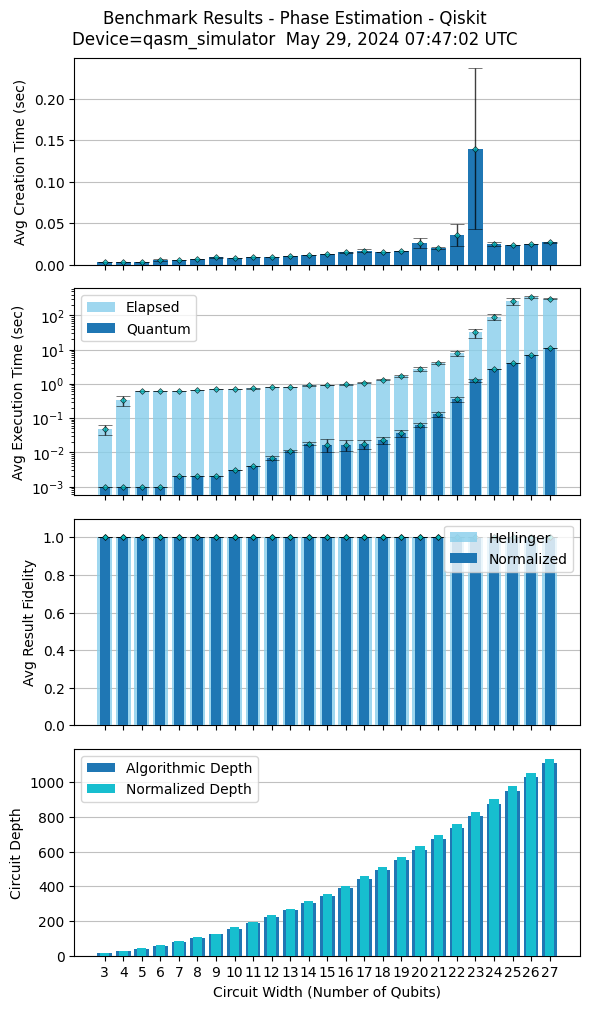

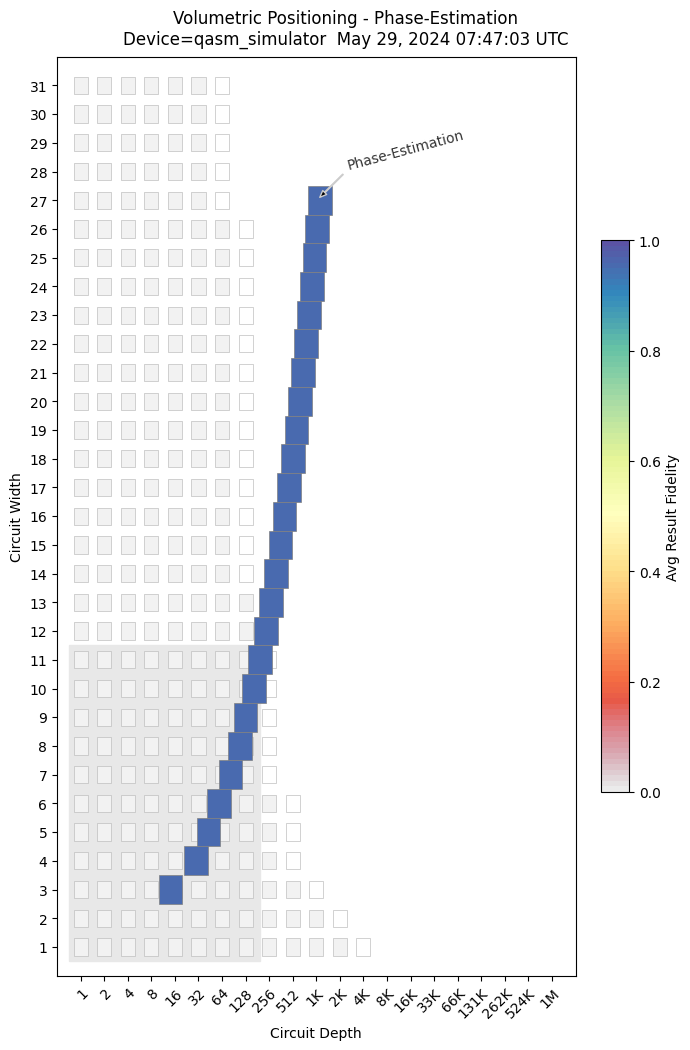

In [3]:
################ Benchmark Loop

# Execute program with default parameters
def run(min_qubits=3, max_qubits=27, skip_qubits=1, max_circuits=3, num_shots=100,         # "Kernel died" after executing max 27qubits
        backend_id='qasm_simulator', provider_backend=None,
        hub="ibm-q", group="open", project="main", exec_options=None,
        context=None):

    print(f"{benchmark_name} Benchmark Program - Qiskit")

    num_state_qubits = 1 # default, not exposed to users, cannot be changed in current implementation

    # validate parameters (smallest circuit is 3 qubits)
    num_state_qubits = max(1, num_state_qubits)
    if max_qubits < num_state_qubits + 2:
        print(f"ERROR: PE Benchmark needs at least {num_state_qubits + 2} qubits to run")
        return
    min_qubits = max(max(3, min_qubits), num_state_qubits + 2)
    skip_qubits = max(1, skip_qubits)
    #print(f"min, max, state = {min_qubits} {max_qubits} {num_state_qubits}")

    # create context identifier
    if context is None: context = f"{benchmark_name} Benchmark"
    
    ##########
    
    # Initialize metrics module
    metrics.init_metrics()

    # Define custom result handler
    def execution_handler(qc, result, num_qubits, theta, num_shots):

        # determine fidelity of result set
        num_counting_qubits = int(num_qubits) - 1
        counts, fidelity = analyze_and_print_result(qc, result, num_counting_qubits, float(theta), num_shots)
        metrics.store_metric(num_qubits, theta, 'fidelity', fidelity)

    # Initialize execution module using the execution result handler above and specified backend_id
    ex.init_execution(execution_handler)
    ex.set_execution_target(backend_id, provider_backend=provider_backend,
            hub=hub, group=group, project=project, exec_options=exec_options,
            context=context)

    ##########
    
    # Execute Benchmark Program N times for multiple circuit sizes
    # Accumulate metrics asynchronously as circuits complete
    for num_qubits in range(min_qubits, max_qubits + 1, skip_qubits):
        
        # reset random seed
        np.random.seed(0)

        # as circuit width grows, the number of counting qubits is increased
        num_counting_qubits = num_qubits - num_state_qubits - 1

        # determine number of circuits to execute for this group
        num_circuits = min(2 ** (num_counting_qubits), max_circuits)
        
        print(f"************\nExecuting [{num_circuits}] circuits with num_qubits = {num_qubits}")
        
        # determine range of secret strings to loop over
        if 2**(num_counting_qubits) <= max_circuits:
            theta_range = [i/(2**(num_counting_qubits)) for i in list(range(num_circuits))]
        else:
            theta_range = [i/(2**(num_counting_qubits)) for i in np.random.choice(2**(num_counting_qubits), num_circuits, False)]

        # loop over limited # of random theta choices
        for theta in theta_range:
            # create the circuit for given qubit size and theta, store time metric
            ts = time.time()

            qc = PhaseEstimation(num_qubits, theta)
            metrics.store_metric(num_qubits, theta, 'create_time', time.time() - ts)

            # collapse the 3 sub-circuit levels used in this benchmark (for qiskit)
            qc2 = qc.decompose().decompose().decompose()
            
            # submit circuit for execution on target (simulator, cloud simulator, or hardware)
            ex.submit_circuit(qc2, num_qubits, theta, num_shots)

        # Wait for some active circuits to complete; report metrics when groups complete
        ex.throttle_execution(metrics.finalize_group)

    # Wait for all active circuits to complete; report metrics when groups complete
    ex.finalize_execution(metrics.finalize_group)

    ##########
    
    # # print a sample circuit
    # print("Sample Circuit:"); print(QC_ if QC_ != None else "  ... too large!")
    # print("\nPhase Operator 'U' = "); print(U_ if U_ != None else "  ... too large!")
    # print("\nInverse QFT Circuit ="); print(QFTI_ if QFTI_ != None else "  ... too large!")

    # Plot metrics for all circuit sizes
    metrics.plot_metrics(f"Benchmark Results - {benchmark_name} - Qiskit")


# if main, execute method
if __name__ == '__main__': run()
